In [1]:
import warnings
warnings.filterwarnings('ignore')

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchaudio
import torchvision.models as vmodels
import torchaudio.models as models
import torchaudio.transforms as transforms
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
import glob
import librosa
import librosa.display
import soundfile as sf
from scipy.interpolate import interp1d
import IPython.display as ipd
import ast
import time
import sys
from nnutils import reshape_mel_spec, RainforestNetV2
from scipy import stats

In [2]:
# Load meta.csv to save metadata for training session
try:
    meta = pd.read_csv('models/meta.csv')
except:
    meta = pd.DataFrame()


In [3]:
# Hyper parameters
class Params():
    EPOCHS = 20
    TRAIN_BATCH_SIZE = 4
    N_MELS = 224
    MEL_SPEC_MAXLEN = 800
    LR = 0.0001
    
    # make both 0 for no noise
    RAND_NOISE_UPPER = 0.1
    RAND_NOISE_LOWER = 0.05
    
    def __to_dict__(self):
        return {key:value for key, value in Params.__dict__.items() if not key.startswith('__') and not callable(key)}
                      
params = Params()

train_full = True

In [4]:
# CUDA
is_cuda = True and torch.cuda.is_available()
cpu = torch.device('cpu')
gpu = torch.device('cuda')
device = gpu if is_cuda else cpu

print ('cuda: ', is_cuda)

torch.cuda.empty_cache()

cuda:  True


In [5]:
# class MelSpecDataset(Dataset):
#     def __init__(self, source_file):
#         self.source = pd.read_csv(source_file)
        
#         mel_specs = []
#         wvs = []
#         sample_rate = int(self.source.iloc[0].sample_rate)
#         mel_trans = transforms.MelSpectrogram(sample_rate=sample_rate, n_mels=params.N_MELS).to(device)
        
#         for idx in tqdm(range(len(self.source))):
#             ex = self.source.iloc[idx]
#             waveform = ex.waveform

#             if isinstance(waveform, str): 
#                 wv = ','.join(ex.waveform.replace('[ ', '[').split())
#                 wv = np.array(ast.literal_eval(wv))
#                 waveform = torch.from_numpy(wv).view(1, -1).to(dtype=torch.float32)

#                 wvs.append(waveform)

#             sample_rate = int(ex.sample_rate)
            
#             waveform = waveform.to(device).view(1, 1, -1)
            
#             mel_spec = mel_trans(waveform)
#             mel_spec = reshape_mel_spec(mel_spec[0], params.MEL_SPEC_MAXLEN).to(cpu)
                        
#             mel_specs.append(mel_spec)

#         if 'mel_spec' in self.source:
#             self.source = self.source.assign(mel_spec=mel_specs)
#         else:
#             self.source.insert(4, "mel_spec", mel_specs, True)
            
#         # drop waveform data for now to save memory
#         self.source = self.source.drop(columns=['waveform'])
        
#         # uncomment to visualize waveform
#         #if len(wvs) > 0:
#         #    self.source = self.source.assign(waveform=wvs)
#     def get_waveform(self, idx):
#         ex = self.source.iloc[idx]
#         return (ex.waveform, ex.sample_rate)
#     def __getitem__(self, idx):
#         ex = self.source.iloc[idx]
#         return (ex.mel_spec, int(ex.species_id))
#     def __len__(self):
#         return len(self.source)

In [6]:
class MelSpecDatasetV2(Dataset):
    def __init__(self):
        self.traint = pd.read_csv( 'data/train_tp.csv' )
        self.trainf = pd.read_csv( 'data/train_fp.csv' )
        self.files = glob.glob( 'data/train/*.flac' )
        self.ids = self.traint.recording_id.unique()
        self.mel_specs = []
        self.labels = []
        
        self.traint["val"] = 1
        self.trainf["val"] = 0
        
        self.train = pd.concat([self.traint, self.trainf])
        
        del self.traint
        del self.trainf
                
        mel_trans = transforms.MelSpectrogram(sample_rate=48000, n_mels=224, n_fft=5000, f_min=90.0, f_max=14000.0).to(device)
        
        f_maxs = []
        f_mins = []
        
        i=0
        for rec_id in tqdm(self.ids):
            path = "data/train/{}.flac".format(rec_id)
            waveform, sample_rate = torchaudio.load(path)
            waveform = waveform.to(device)
            mel_spec = mel_trans(waveform).repeat(3, 1, 1).to(cpu)
            
            del waveform
            torch.cuda.empty_cache()
                        
            self.mel_specs.append(mel_spec)
            
            subset = self.train[self.train['recording_id'] == rec_id]
            label = (RAND_NOISE_UPPER - RAND_NOISE_LOWER) * torch.rand(24) + RAND_NOISE_LOWER
            
            for idx in range(len(subset)):
                ex = subset.iloc[idx]
                
                f_maxs.append(ex.f_max)
                f_mins.append(ex.f_min)
                
                species_id = ex.species_id
                label[species_id] = ex.val
            self.labels.append(label)
            
            #if i > 9:
            i+=1
            
        #print (stats.describe(f_maxs))
        #print (stats.describe(f_mins))
        
        del mel_trans
        torch.cuda.empty_cache()
        
    def __getitem__(self, idx):
        return (self.mel_specs[idx], self.labels[idx])
    def __len__(self):
        return len(self.mel_specs)

In [7]:
trainset = MelSpecDatasetV2()

1132


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([0.0974, 0.0982, 0.0827, 0.0926, 0.0771, 0.0967, 0.0724, 0.0857, 0.0939,
        0.0772, 0.0533, 0.0784, 0.0603, 0.0500, 1.0000, 0.0502, 0.0819, 0.0798,
        0.0851, 0.0712, 0.0708, 0.0863, 0.0936, 0.0626])


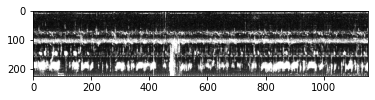

In [8]:
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

ms, l = trainset[0]
print (l)
imshow(ms)

In [9]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=params.TRAIN_BATCH_SIZE,shuffle=True)

In [10]:
model = RainforestNetV2().to(device)
model.train()
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=params.LR)

In [11]:
print (len(trainset))

1132


In [12]:
start_time = time.time()
losses = []
losses_detail = []

for epoch in range(params.EPOCHS):
    running_loss = 0.0
    t = tqdm(trainloader, desc="epoch {}/{}, running loss: {}".format(epoch+1, params.EPOCHS, 0.0))
    for i, data in enumerate(t):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
                        
        optimizer.zero_grad()
                
        output = model(inputs)
        loss = criterion(output, labels)
        
        loss.backward()
        optimizer.step()
        
        del inputs
        del labels
        
        torch.cuda.empty_cache()
        
        running_loss += loss.item()
        losses_detail.append(loss.item())
        if i % 50 == 49:    # print every 50 mini-batches
            #print('[%d %5d] loss: %.3f' % (epoch+1, i+1, running_loss / 50))
            
            losses.append(running_loss/50)
            t.set_description("epoch {}/{}, running_loss: {:.2f}".format(epoch+1, params.EPOCHS, running_loss/50))
            t.refresh()
            
            running_loss = 0.0
            
end_time = time.time()
print ('\n-------- DONE --------')
print ('start time: {}'.format(start_time))
print ('end time: {}\n'.format(end_time))

duration = end_time-start_time
print ('training duration: {}'.format(duration))

model_path = 'models/rainforest{}.pt'.format(end_time)
torch.save(model.state_dict(), model_path)

mdata = params.__to_dict__()
mdata.update({
    'start_time': start_time,
    'end_time': end_time,
    'train_duration': duration,
    'model_path': model_path,
})
meta = meta.append(mdata, ignore_index=True)
meta.to_csv("models/meta.csv", index=False, float_format='%.5f')



-------- DONE --------
start time: 1608768229.3875253
end time: 1608769852.3191528

training duration: 1622.9316275119781


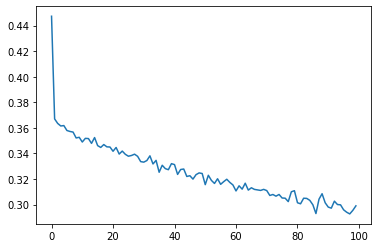

In [13]:
fig, ax = plt.subplots()
ax.plot(losses)